In [14]:
import numpy as np
from vorothreshold.read_funcs import read_adjfile, read_voronoi_vide, voro_in_vide_voids, vide_voids_cat
from vorothreshold import voronoi_threshold
from vorothreshold.overlaps import compute_max_dist2, overlapping_fraction, select_overlaps
import pickle
from numba import jit
import matplotlib.pyplot as plt

In [2]:
#Vide info

dataPortion="all"
untrimmed = True
fullName = 'example_observation'
if untrimmed:
    prefix = "untrimmed_"
else:
    prefix = ""

vide_out = 'data/lightcone/examples/example_observation/sample_example_observation/'
adjfile = 'adj_example_observation.dat'

In [3]:
neighbor_ptr, neighbor_ids = read_adjfile(vide_out + adjfile)
print(neighbor_ptr.shape[0],neighbor_ids.shape[0])

ids_voro, VoroVol, VoroXYZ, RA, Dec, redshift = read_voronoi_vide(vide_out,fullName)
print(ids_voro.shape)
Ntot_part = ids_voro.shape[0]

barycenter,radius,redshift_vds,voidID,RA,DEC,coreID,core_dens,core_pos,RAcore,DECcore,redshift_core = vide_voids_cat(vide_out,fullName,
    values_out=['barycenter','radius','redshift','voidID','RA','DEC','coreID','core_dens','core_pos','RAcore','DECcore','redshift_core'])
print(barycenter.shape)

164648 1147080
(164647,)
(452, 3)


/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


[0.00726143 0.01186588 0.01647034 0.02107479 0.02567925 0.03028371
 0.03488816 0.03949262 0.04409707 0.04870153 0.05330598 0.05791044
 0.06251489 0.06711935 0.07172381 0.07632826 0.08093272 0.08553717
 0.09014163 0.09474609 0.09935054 0.103955   0.10855946 0.11316391
 0.11776837 0.12237282 0.12697728 0.13158174 0.1361862  0.14079064
 0.1453951  0.14999956]


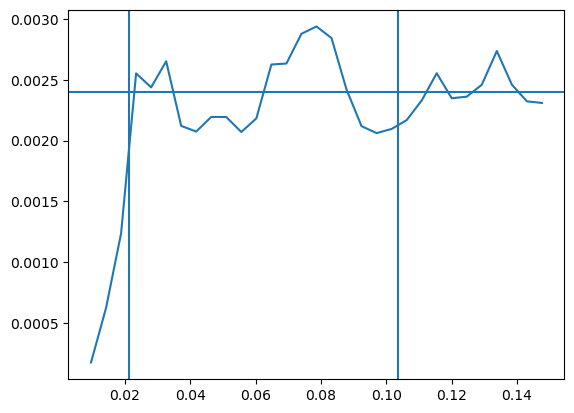

In [4]:
from cosmodata_functions.functions_for_data import ComovingDistanceOverh, ComovingDistanceOverh_explicit
import healpy as hp

mask_gal_file = 'data/lightcone/examples/example_observation/sample_example_observation/mask_map.fits'
mask = hp.read_map(mask_gal_file)
sky_frac = np.sum(mask)/mask.shape[0]
Omega_m = 0.32
w0=-1.
wa=0.
dist_z = ComovingDistanceOverh(Omega_m,w0,wa)
hist_z, z_bins = np.histogram(redshift,bins=31)

comov3 = dist_z.get_dist(z_bins)**3
shell_vol = 4*np.pi/3.*sky_frac*(comov3[1:] - comov3[:-1])
print(z_bins)
z_mean = 0.5 * (z_bins[1:] + z_bins[:-1])
plt.plot(z_mean,hist_z/shell_vol)
plt.axhline(np.mean((hist_z/shell_vol)[3:]))
plt.axvline(z_bins[3])

iv = np.argmax(radius)
ID_core = coreID[iv]
zDens = np.ones(Ntot_part) *np.mean((hist_z/shell_vol)[3:])
plt.axvline(redshift[ID_core])

In [5]:
threshold = [0.3]
ID_core_arr = np.array([ID_core])
print(coreID.shape)
#IDthresholds = np.zeros(Ntot_part,dtype=np.int_)
ID_voro_dict, Xcm, Vol_interp, Ncells_in_void, ell_eigenvalues, ell_eigenvectors = voronoi_threshold(threshold,coreID,neighbor_ptr,neighbor_ids,VoroXYZ,VoroVol,zDens,nthreads=-1,verbose=True)
print(Xcm.shape)

(452,)

    nthreads set to 32

    computation started


/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/vorothreshold/voronoi_threshold.py:172: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  cluster_accretion(ID_voro_dict[iv],ID_core_arr[iv],numPart,neighbor_ptr,neighbor_ids,Nthresholds,threshold_arr,VoroXYZ,VoroVol,zDens)


    done, 0 h 0 min 10.3363356590271 sec. 

(452, 1, 3)


In [6]:
iv_test = (np.arange(coreID.shape[0])[coreID == 29625])[0]
print(VoroVol[coreID[iv_test]])
print(ID_voro_dict[0].shape)
print(ID_voro_dict[iv][:int(Ncells_in_void[iv]+1)].shape)
print(np.max(Ncells_in_void))


336.66006
(49394,)
(475,)
474.81436972543776


(452, 1, 3)
(597,)


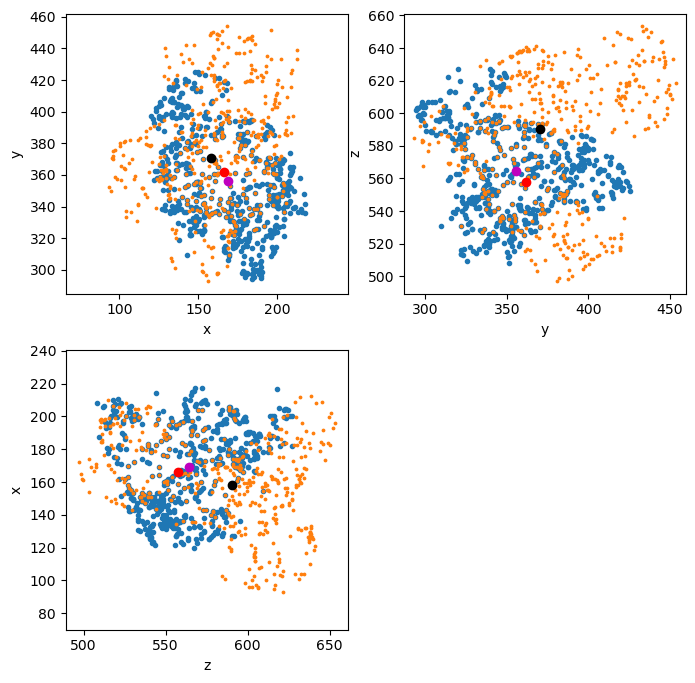

In [7]:

#Unique_IDS = zones2Parts[voidID[iv]].partIDs
print(Xcm.shape)
Xcm_interp = Xcm[iv,0,:]
IDthresholds = ID_voro_dict[iv][:int(Ncells_in_void[iv,0]+1)]
asd = voro_in_vide_voids(vide_out,fullName)
Unique_IDS = asd.get_voro_from_uniqueID(voidID[iv])
print(np.array(Unique_IDS).shape)
fig = plt.figure(figsize=(8,8))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)

    ax[i].scatter(VoroXYZ[Unique_IDS,i%3],VoroXYZ[Unique_IDS,(i+1)%3],s=9)
    ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=3)
    ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3],c='k')
    ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
    ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3])
    ax[i].set_ylabel(['x','y','z'][(i+1)%3])

In [8]:
#max_dist_2 = compute_max_dist2(Ncells_in_void[:,0],Xcm[:,0,:],VoroXYZ,ID_voro_dict)
max_dist_2 = compute_max_dist2(Ncells_in_void[:,0],Xcm[:,0,:],VoroXYZ,ID_voro_dict)

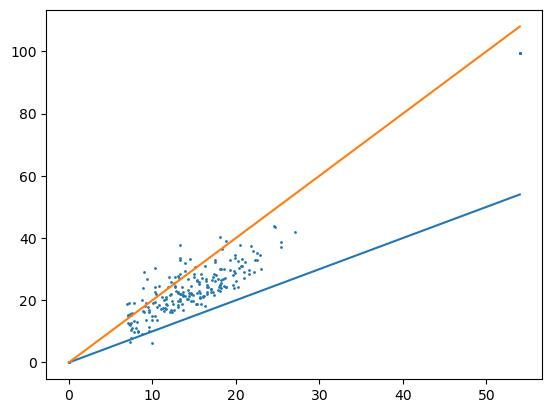

In [9]:
Rth = (Vol_interp[:,0] * 3 / (4.*np.pi)) ** (1/3)
plt.scatter(Rth,max_dist_2**0.5,s=1)
#plt.scatter(radius,max_dist_2**0.5)
plt.plot([np.min(Rth),np.max(Rth)],[np.min(Rth),np.max(Rth)])
plt.plot([np.min(Rth),np.max(Rth)],[2*np.min(Rth),2*np.max(Rth)])



In [20]:
ids_ovlp, Vol_ovlp, Vol_ovlp_frac, num_ovlps = overlapping_fraction(Xcm[:,0,:], Vol_interp[:,0], Ncells_in_void[:,0], VoroXYZ, VoroVol, ID_voro_dict)


IDs_in_sphere started.

    nthreads set to 32

    Lbox not passed, using xyz_vds as reference:
    min(xyz_vds) = 34.70551857786532 113.85829433750433 427.2683432667779
    max(xyz_vds) = 331.32019182903076 757.994024385784 805.7619411093509
    Lbox = 644.1357300482796

    ngrid not passed. Set to optimal value: 6
    done, 0 h 0 min 3.838539123535156e-05 sec.

    computation started (periodic-boundaries condition off)
    done, 0 h 0 min 0.020588159561157227 sec. 



In [21]:
#id_ovlp = np.arange(num_ovlps.shape[0])[num_ovlps>0]
#print(num_ovlps[id_ovlp])
print(num_ovlps[iv],ids_ovlp[iv,:num_ovlps[iv]],Vol_ovlp[iv,:num_ovlps[iv]],Vol_ovlp_frac[iv,:num_ovlps[iv]])

8 [151 216 130 234 167 385 404 406] [  1077.12329102   4157.88867188   3908.86181641   7549.578125
 659857.875      659857.5625     659857.5625       4727.73583984] [0.03006043 0.06650353 0.09982111 0.1474195  1.         1.
 1.         0.14741816]


(452, 1, 3)


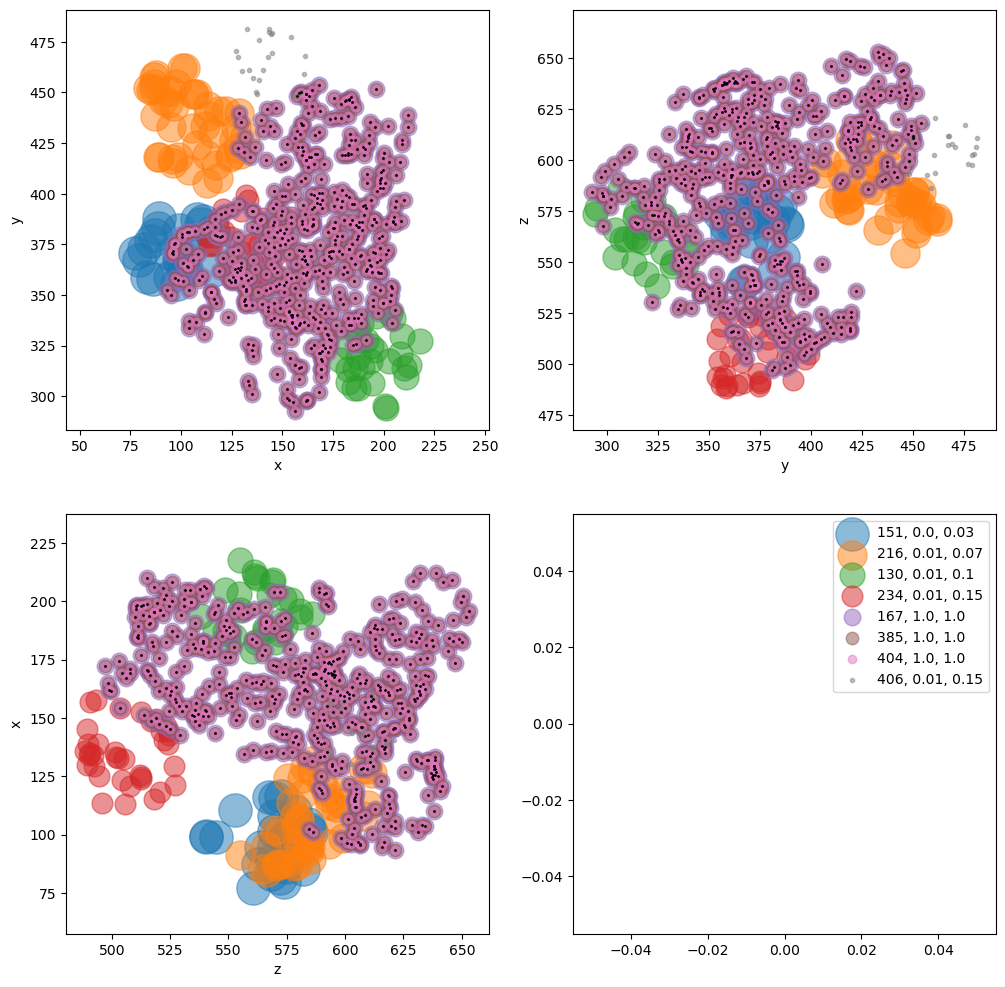

In [12]:
print(Xcm.shape)
asd = voro_in_vide_voids(vide_out,fullName)
Ncells_loop = int(Ncells_in_void[iv,0]) + int(round(Ncells_in_void[iv,0]%1))
Vol_tot_ref = np.sum(VoroVol[ID_voro_dict[iv][:Ncells_loop]])
#print(Vol_tot_ref,Vol_interp[iv,0],Ncells_loop,VoroVol.shape,ID_voro_dict[iv].shape)
fig = plt.figure(figsize=(12,12))
ax = dict()
for i in range(4):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
progr = 0
for id in ids_ovlp[iv,:num_ovlps[iv]]:
    Xcm_interp = Xcm[id,0,:]
    IDthresholds = ID_voro_dict[id][:int(Ncells_in_void[id,0]+1)]

    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=(3*(num_ovlps[iv] - progr))**2,alpha=0.5)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
        ax[i].axis('equal')
        ax[i].set_xlabel(['x','y','z'][i%3])
        ax[i].set_ylabel(['x','y','z'][(i+1)%3])
    Ncells_loop = int(Ncells_in_void[id,0]) + int(round(Ncells_in_void[id,0]%1))
    Vol_tot_id = np.sum(VoroVol[ID_voro_dict[id][:Ncells_loop]])
    #print(Vol_ovlp[iv,progr],Vol_ovlp[iv,:8],Vol_tot_id,Vol_tot_id)
    ax[3].scatter([np.nan],[np.nan],s=(3*(num_ovlps[iv] - progr))**2,alpha=0.5,label=str(id)+', '+str(round(Vol_ovlp[iv,progr]/Vol_tot_ref,2))+', '+str(round(Vol_ovlp[iv,progr]/Vol_tot_id,2)))
    progr +=1
Xcm_interp = Xcm[iv,0,:]
IDthresholds = ID_voro_dict[iv][:int(Ncells_in_void[iv,0]+1)]
for i in range(3):
    ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=1,c='k')
        #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
    #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
    #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3])
    ax[i].set_ylabel(['x','y','z'][(i+1)%3])
ax[3].legend()

In [54]:
id_selected = np.arange(Vol_interp.shape[0])[Vol_interp[:,0] > 0]

print(num_ovlps.shape)



import time
t0 = time.time()
id_out = select_overlaps(0.3,id_selected, ids_ovlp, Vol_ovlp_frac, num_ovlps)
print(time.time()-t0)

(452,)
0.00011038780212402344


In [53]:
print(id_out.shape,id_out)


(201,) [  0   4   6   8   9  11  12  13  14  15  19  20  21  24  26  27  28  29
  30  31  32  35  36  38  39  42  43  46  47  49  50  52  53  54  57  62
  63  65  66  69  70  71  73  76  77  78  82  83  84  88  92  93  94  95
  96  97  98 101 102 104 105 107 109 111 114 116 117 120 123 125 126 130
 133 134 136 137 144 149 151 155 157 161 162 163 164 165 168 169 170 172
 173 176 178 180 181 182 183 190 192 194 196 198 202 204 206 207 208 210
 214 215 216 218 220 221 224 225 226 227 228 229 232 234 237 238 240 243
 246 247 248 255 257 260 261 263 266 269 270 273 274 275 277 280 282 285
 287 289 292 294 295 300 304 306 311 312 314 316 318 320 326 331 332 336
 345 346 347 351 353 362 365 367 368 370 372 376 386 388 392 393 395 399
 401 402 403 405 406 410 412 415 416 422 425 426 427 430 432 433 437 438
 439 443 448]
